# Загрузка Pandas и очистка данных

## В задачи пректа входит:

 - Удалить из датафрейма столбцы, данные в которых представлены не числами (это вы уже сделали, и нужно просто повторить знакомые действия, но в этот раз выполнить данный шаг в последнюю очередь).
 - Избавиться от пропущенных (None) значений (на предыдущем шаге мы делали это самым грубым из всех возможных способов; сейчас попробуем подойти к процессу более гибко).
 - Создать новые столбцы с данными, используя для этого информацию, содержащуюся в других столбцах датафрейма (например, можно добавить столбец, сообщающий, сколько дней прошло со дня публикации последнего отзыва, отображённого на сайте).

/  
/  
/  
/  
/  


## Описание датасета
Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

 - **Restaurant_id** — идентификационный номер ресторана / сети ресторанов;
 - **City** — город, в котором находится ресторан;
 - **Cuisine Style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
 - **Ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города;
 - **Rating** — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
 - **Price Range** — диапазон цен в ресторане;
 - **Number of Reviews** — количество отзывов о ресторане;
 - **Reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;
 - **URL_TA** — URL страницы ресторана на TripAdvosor;
 - **ID_TA** — идентификатор ресторана в базе данных TripAdvisor.



In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import scipy
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

import os

In [2]:
# функции используемые в ноутбуке
def pre_process(df):
    df['Restaurant_id_enc'] = df.Restaurant_id.str[3:].astype(int)

    df = pd.concat([df,pd.get_dummies(df.City)],axis=1)

    df.Cuisine_Style = df.Cuisine_Style.fillna("['Nan_Style']").str[2:-2].str.split("', '")
    cuisine_styles = sorted(set(df.Cuisine_Style.sum()))
    for style in cuisine_styles:
        df[style] = df.Cuisine_Style.apply(lambda x: int(style in x))

    scaler = MinMaxScaler()
    grouped_by_City = df.groupby('City')
    for group in grouped_by_City.groups:
        index = grouped_by_City.groups[group]
        scaled_values = scaler.fit_transform(df[['Ranking']].loc[index])
        df.Ranking.loc[index] = pd.Series(scaled_values.flatten(), index=index)
    
    price_range_encod = {'$': 1, '$$ - $$$': 2, '$$$$': 3, 'no range': 0}
    df['Price_Range_enc'] = df.Price_Range.fillna('no range').map(price_range_encod)

    df.Number_of_Reviews.fillna(1,inplace=True)
    scaler = MinMaxScaler()
    for group in grouped_by_City.groups:
        index = grouped_by_City.groups[group]
        scaled_values = scaler.fit_transform(df[['Number_of_Reviews']].loc[index])
        df.Number_of_Reviews.loc[index] = pd.Series(scaled_values.flatten(), index=index)

    df.ID_TA = df.ID_TA.str[1:].astype(int)
    
    return df

def features_combination(features_list):
    pass

In [3]:
# установка параметров
%pylab inline

pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

path = './Preproject3_data/'
# path = '/kaggle/input/sf-dst-restaurant-rating/'

RANDOM_SEED = 42

Populating the interactive namespace from numpy and matplotlib


In [4]:
# проверка пути и имен файлов
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Preproject3_data/kaggle_task.csv
./Preproject3_data/main_task.csv
./Preproject3_data/sample_submission.csv


In [5]:
# чтение данных
df_train = pd.read_csv(f'{path}main_task.csv')
df_test = pd.read_csv(f'{path}kaggle_task.csv')
sample_submission = pd.read_csv(f'{path}sample_submission.csv')

### Ознакомление с данными
#### df_train

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
13941,id_958,Berlin,"['German', 'Cafe', 'European', 'Central Europe...",959.0,4.5,$$ - $$$,46.0,[['What a Wonderful Little Place for Breakfas....,/Restaurant_Review-g187323-d2086852-Reviews-Ca...,d2086852
6794,id_4514,Barcelona,NaN,4515.0,4.5,NaN,2.0,"[[], []]",/Restaurant_Review-g187497-d5795010-Reviews-Lu...,d5795010
23571,id_14932,London,NaN,14943.0,3.0,NaN,7.0,"[['nice tasting wide variety of food', 'Take a...",/Restaurant_Review-g186338-d10108855-Reviews-E...,d10108855
419,id_5908,Berlin,['Italian'],5910.0,3.5,$$ - $$$,3.0,"[[], []]",/Restaurant_Review-g187323-d9456227-Reviews-Ei...,d9456227
29468,id_9193,Paris,"['French', 'Bar', 'European', 'Pub']",9195.0,3.5,$$ - $$$,69.0,[['More everyday dining that special night ou....,/Restaurant_Review-g187147-d2718440-Reviews-La...,d2718440


#### df_test

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
1031,id_1031,London,"['Mediterranean', 'European', 'Turkish', 'Midd...",147.0,$$ - $$$,1248.0,"[['Ah.Ma.Zing', 'Turkish twist to middle easte...",/Restaurant_Review-g186338-d734125-Reviews-Kaz...,d734125
8223,id_8223,Rome,"['Italian', 'Delicatessen']",4056.0,$,33.0,"[['Brilliant Deli', 'Loved this!!'], ['04/22/2...",/Restaurant_Review-g187791-d4453333-Reviews-If...,d4453333
5643,id_5643,Madrid,['Spanish'],8670.0,NaN,5.0,"[[], []]",/Restaurant_Review-g187514-d7732816-Reviews-Re...,d7732816
6695,id_6695,Madrid,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",2567.0,$$ - $$$,101.0,"[['Went Twice', 'Nice pizza'], ['11/28/2017', ...",/Restaurant_Review-g187514-d7621864-Reviews-La...,d7621864
2021,id_2021,Warsaw,['International'],1603.0,NaN,2.0,"[[], []]",/Restaurant_Review-g274856-d1773677-Reviews-Al...,d1773677


#### sample_submission

In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
sample_submission.sample(5)

,Restaurant_id,Rating
5930,id_5930,5.0
3924,id_3924,3.0
7994,id_7994,4.0
5284,id_5284,2.5
3871,id_3871,1.0


Для корректной обработки признаков объединяем трейн и тест в один датасет ***data***

In [12]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Теперь посмотрим на полученный датасет

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
22706,id_4048,Berlin,NaN,4050.0,NaN,15.0,"[['Very tasty italian food!', 'Reasonable quic...",/Restaurant_Review-g187323-d2156563-Reviews-La...,d2156563,1,4.0
14337,id_1772,Prague,"['International', 'Pub', 'Gastropub', 'Bar', '...",1775.0,$$ - $$$,27.0,"[['Lovely summer BBQ', 'Hidden restaurant'], [...",/Restaurant_Review-g274707-d7123526-Reviews-Na...,d7123526,1,4.0
16806,id_7936,London,NaN,7945.0,NaN,5.0,"[['Fantastic food and great vibe', 'What a gre...",/Restaurant_Review-g186338-d11547915-Reviews-W...,d11547915,1,5.0
14019,id_1107,Oporto,"['European', 'Portuguese']",1108.0,$,34.0,[['Good local food in locals place good price'...,/Restaurant_Review-g189180-d2049390-Reviews-Ma...,d2049390,1,3.5
33377,id_2556,Munich,NaN,2574.0,NaN,19.0,"[['Good Italian Restaurant', 'A little disappo...",/Restaurant_Review-g187309-d5510652-Reviews-Vi...,d5510652,1,3.0


In [15]:
for col in data.columns: print('{:20} {}'.format(col, type(data.loc[0][col])))

Restaurant_id        <class 'str'>
City                 <class 'str'>
Cuisine Style        <class 'str'>
Ranking              <class 'numpy.float64'>
Price Range          <class 'str'>
Number of Reviews    <class 'numpy.float64'>
Reviews              <class 'str'>
URL_TA               <class 'str'>
ID_TA                <class 'str'>
sample               <class 'numpy.int64'>
Rating               <class 'numpy.float64'>


Пропуски в явном виде *(NaN)* наблюдаются в четырех признаках: `Cuisine Style`, `Price Range`, `Number of Reviews` и `Reviews`. Кроме трех числовых признаков `Ranking`, `Rating` и `Number of Reviews`(один из них, `Rating` - целевая переменная) и одного вспомогательного временного столбца `sample` признаки представлены строками.

In [16]:
# изменеие имен колонок для возможности обращения к колонкам как к атрибутам DataFrame
data.columns = data.columns.str.replace(' ','_')

## Работа с признаками

Сначала рассмотрим существующие признаки, выберем способы их предобработки, извлечем из существующих признаков информацию для создания новых.  
Затем предобработаем существующие признаки согласно выбранным способам.  
После этого создадим новые, при необходимости предобработаем и их.

### Restaurant_id
Согласно описанию - идентификационный номер ресторана / сети ресторанов   

Посмотрим на значения признака

In [17]:
data.Restaurant_id.sample(5)

39118    id_8628
10897     id_984
47513    id_2777
45212    id_4617
14665     id_207
Name: Restaurant_id, dtype: object

Значения признака строковые, формата **'id_ЧИСЛО'**, где **ЧИСЛО** - некоторое целое число.
Проверим, все ли значения выглядит подобным образом, для этого убедимся что первые три символа везде **'id_'** и что все значения после первых 3-х симвлов содержат только цифры:

In [18]:
(data.Restaurant_id.str[:3] == 'id_').all(), data.Restaurant_id.str[3:].str.isnumeric().all()

(True, True)

Всё так и есть. Можно отбросить первые три символа(они везде одинаковые и потому не несут никакой информации) и в качестве значения признака принять приведенное к числовому виду **ЧИСЛО**:

Сопоставление `Restaurant id` с другими признаками из набора данных показало что как правило `Ranking` и **ЧИСЛО** в `Restaurant id` либо совпадают с точностью до 1 либо очень близки (возможно **ЧИСЛО** это `Ranking` в момент внесения ресторана в набор данных). Это наблюдение делает информативным казалось бы бесполезный признак, он будет впоследствии использован для создания новых.

Пропусков в признаке нет.

### City
Согласно описанию - город, в котором находится ресторан   

Посмотрим на значения признака и заодно проверим, если пропускив неявном виде:

In [19]:
data.City.unique()

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

Пропусков, выбросов нет. Остается привести признак в числовой вид, применив dummy-кодирование.

### Cuisine_Style
согласно описанию - кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане.  

Посмотрим как устроен признак:

In [20]:
data.Cuisine_Style.sample(5,random_state=RANDOM_SEED)

33553                                          ['Italian']
9427                                                   NaN
199      ['Middle Eastern', 'Vegetarian Friendly', 'Veg...
12447                                                  NaN
39489                                                  NaN
Name: Cuisine_Style, dtype: object

Заполним пропуски в признаке строковым значением *['Nan_Style']* и затем преобразуем строковое представление списков непосредственно в списки.

После чего мы создадим dummy-признаки по значениям в списках полученных из строковых значений в `Cuisine_Style` 

Сохраним список этих значений, он нам понадобится в дальнейшем:

In [21]:
%%time
cuisine_styles = sorted(set(data.Cuisine_Style.fillna("['Nan_Style']").str[2:-2].str.split("', '").sum()))

Wall time: 22.8 s


Проверим, не было ли в признаке пропусков в неявном виде (т.е. в виде пустых строк, строкового представления пустого списка и т.д.). Если это так, то в `cuisine_styles` должна оказаться пустая строка.

In [22]:
'' in cuisine_styles

False

### Ranking
Согласно описанию - место, которое занимает данный ресторан среди всех ресторанов своего города

Признак числовой.  
Пропусков нет

В каждом городе разное количество ресторанов, поэтому и диапозон `Ranking` в каждом городе различный (что приводит к тому что наихудший ресторан в маленьком городе будет иметь такой же `Ranking` как и отличный ресторан в мегаполисе). Такая разница масштабов может помешать модели, имеет смысл отнормировать  Ranking в каждом городе отдельно, что мы и сделаем. 

Так же можно использовать как оценку количества ресторанов в городе максимальную величину `Ranking` для каждого города. Эта величина будет использована как самостоятельный признак и будет участвовать в создании других новых признаков.

Сохраним оценку количества ресторанов в городе, она нам понадобится при создании новых признаков.

In [23]:
num_rest_estimate = data.groupby('City').Ranking.max() 

### Price_Range
Согласно описанию - диапазон цен в ресторане   

Посмотрим на значения признака:

In [24]:
data.Price_Range.unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

Заполним пропуски строковым значением 'no range' и затем приведем признак к числовому виду, закодировав каждый из четырех вариантов значений соответствующим числом от 0 (для 'no range') до 3 (для высокого ценового диапзона)

### Number_of_Reviews
Согласно описанию - количество отзывов о ресторане  

Признак в числовой форме.
Пропуски в признаке есть:

In [25]:
data.Number_of_Reviews.isna().sum()

3200

Посмотрим на распределение признака в области 0:

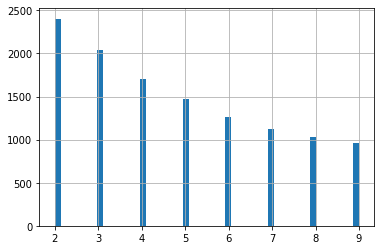

In [26]:
data.Number_of_Reviews[data.Number_of_Reviews<10].hist(bins = 50);

### ++++++++++++++++++++++++++++++++++++++++++++++++++

In [27]:
data.Reviews.fillna("[[], []]", inplace=True)

In [28]:
data.Reviews[data.Number_of_Reviews.isna()]

7                                        [[], []]
25                                       [[], []]
53                                       [[], []]
74               [["Nova' Doba"], ['01/26/2017']]
81                                       [[], []]
                           ...                   
49965                                    [[], []]
49972    [['Personal expirence'], ['10/27/2017']]
49986                                    [[], []]
49988                                    [[], []]
49989    [['I love this place!'], ['08/24/2015']]
Name: Reviews, Length: 3200, dtype: object

In [29]:
ddd = data.Reviews.fillna("[[], []]")[data.Number_of_Reviews.isna()] == '[[], []]'
ddd.value_counts()

True     2024
False    1176
Name: Reviews, dtype: int64

### ++++++++++++++++++++++++++++++++++++++++++++++++++

Если сопоставить количество пропусков и распределение, то может возникнуть предположение, что пропуски подразумевают значение 0 или 1. Такая версия не испортит общий вид распределения. Заполнение пропусков 1 в отличии от заполнения 0 упростит использование данного признака при создании признаков новых .  
Поэтому заполним пропуски 1. Этим обработка признака и ограничится.

### ID_TA
Согласно описанию - идентификатор ресторана в базе данных TripAdvisor

Посмотрим на значения признака:

In [30]:
data.ID_TA[:5]

0    d10746918
1     d6674944
2    d13129638
3      d680417
4     d1112354
Name: ID_TA, dtype: object

Значения признака строковые, формата **'dЧИСЛО'**, где **ЧИСЛО** - некоторое целое число. Проверим, все ли значения выглядит подобным образом, для этого убедимся что первый символ везде 'd' и что все символы кроме первого - только цифры:

In [31]:
(data.ID_TA.str[0] == 'd').all(), (data.ID_TA.str[1:].str.isnumeric()).all()

(True, True)

Обработаем признак -  примем в качесвте значения приведенную к числовому виду его цифровая часть (т.е. **ЧИСЛО**).  
В работе будет использоваться гипотеза о том что цифровая часть отражает хронологический порядок появления ресторана в базе данных. 

### Reviews
Согласно описанию - данные о не более чем двух последних отзывах, которые отображаются на сайте ресторана  
**ИДЕИ:дата раннего, дата позднего, срок от последнего отзыва до тоталпоследнего отзыва, соотносятся с ID_TA?  разброс в датах отзывов, наличие пропуска, тональность отзыва, длинна отзыва, грамматичнские ошибки в отзыве**

Посмотрим на значения признака:

In [32]:
data.Reviews[:5]

0                                             [[], []]
1    [['Very good reviews!', 'Fine dining in Hakani...
2    [['Better than the Links', 'Ivy Black'], ['12/...
3    [['Most exquisite', 'Delicious and authentic']...
4    [['Always the best in bratislava', 'Very good ...
Name: Reviews, dtype: object

Признак строковый,в нем есть неявные пропуски (значения "[[], []]"), при работе с признаком надо будет учитывать их наличие. Удалять наблюдения с такими значениями не следует ввиду их значительного количества:

In [33]:
(data.Reviews == '[[], []]').sum()

8114

In [34]:
print('В признаке пропусков в явном виде {}, заполним их строковым значением "[[], []]"'.format(data.Reviews.isna().sum()))
data.Reviews.fillna('[[], []]',inplace=True)

В признаке пропусков в явном виде 0, заполним их строковым значением "[[], []]"


При работе с  признаком:
 - отделим и сохраним текстовую составляющую (собственно отзывы)
 - получим список дат отзывовов.   
 На основе этой информации позднее создадим новые признаки, а так же заполним пропуски в признаке `Number_of_Reviews`.

In [35]:
Review_texts = data.Reviews.apply(lambda x:x[: x.find('], [')+1]).str.replace("[\[\]]", "")

In [36]:
str_to_data = lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').date() # функция перевода str в datetime
today = datetime.datetime.today().date()
# Получим pd.Series содержащую списки дат отзывов
review_date_lists = data.Reviews.apply(lambda x:x[ x.find('], [')+3:]).str.replace("[\[\]' ]", "").str.split(",")

### URL_TA
Согласно описанию - URL страницы ресторана на TripAdvosor  

Посмотрим на значения признака:

In [37]:
for s in data.URL_TA[:5]: print(s)

/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html
/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html
/Restaurant_Review-g186525-d13129638-Reviews-Black_Ivy-Edinburgh_Scotland.html
/Restaurant_Review-g186338-d680417-Reviews-Quirinale-London_England.html
/Restaurant_Review-g274924-d1112354-Reviews-Massimo_Ristorante-Bratislava_Bratislava_Region.html


Значения строковые, в строке присутсвует какойто индентификатор формата 'g123456', затем ID_TA, название ресторана, город/регион.  
Получим название и попытаемся такой признак обработать и применить.

In [38]:
rest_names = data.URL_TA.apply(lambda x: x[x.find('Reviews-')+8: x.find('-',x.find('Reviews-')+8)])

Вызывает любопытсво индентификатор формата 'g123456'. Вычленим его из `URL_TA`.

In [39]:
g_fig = data.URL_TA.apply(lambda x: int(x[x.find('-g')+2:x.find('-d')]))

К сожалению ни изучение распределения индентификатора (его цифровой части), ни рассмотрение его уникальных значений не навело на какие-либо разумные предположения о его природе. Тем не менее  попробуем применить его в качестве фактора в нашей модели.

### Реализация предобработки.
Проведем кодирование существующих признаков в соотвтетсвии с принятыми решениями о способах предобработки.

In [40]:
%%time
data = pre_process(data)

C:\Users\GANSOR-PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\GANSOR-PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\GANSOR-PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Wall time: 26.2 s


C:\Users\GANSOR-PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\GANSOR-PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\GANSOR-PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

### Создание новых признаков

In [44]:
data.head(1).Pub

0    1
Name: Pub, dtype: int64

In [42]:
df_test.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0


Новый признак `population` - население города, в которм расположен ресторан. Признак возможно интресен и сам по себе, но с большей вероятнотью интересен в сочетании с другими признаками.

In [250]:
population_dict = {
    'Paris':2140526, 'Stockholm':961609, 'London': 8787892, 'Berlin':3601131, 'Munich':1456039, 
    'Oporto':240000,'Milan':1366180, 'Bratislava': 425923, 'Vienna':1840573, 'Rome': 2872800, 
    'Barcelona':1620343, 'Madrid':3223334,'Dublin':553165, 'Brussels':1198726, 'Zurich': 428000, 
    'Warsaw':1758143, 'Budapest':1749734, 'Copenhagen':615993,'Amsterdam':859732, 'Lyon':515695, 
    'Hamburg':1830584, 'Lisbon':506654, 'Prague':1280508, 'Oslo':673469,'Helsinki':643272, 
    'Edinburgh':524900 ,'Geneva':499000, 'Ljubljana':258900, 'Athens':655780, 'Luxembourg':115227, 
    'Krakow':766739
}

data['City_population'] = data.City.map(population_dict)

Новый признак `styles_num` - количество стилей кухни, представленных в ресторане.

In [251]:
data['styles_num'] = data.apply(lambda x: 0 if x.Nan_Style else len(x.Cuisine_Style),axis=1)

Новый признак `ranking_change` - определяется как ***Restaurant_id_enc - Ranking + 1***, где ***Restaurant_id_enc*** цифровая часть `Restaurant_id`, основан на предположении, что цифровая часть `Restaurant_id` определяется как `Ranking` в момент внесения в базу

In [252]:
data['ranking_change'] = data.Restaurant_id_enc - data.Ranking

Новый признак `num_rest_estimate` оценка количества ресторанов в городе (оценкой служит Ranking.max())

In [253]:
data['num_rest_estimate'] = data.apply(lambda x: num_rest_estimate[x.City], axis = 1)

Новый признак `rest_per_capita` -  оценочное (по Ranking.max()) количество ресторанов на душу населения.

In [254]:
data ['rest_per_capita'] = data.apply(lambda x: num_rest_estimate[x.City]/x.City_population, axis = 1)

Новый признак `reviews_per_capital` - количество отзывов а душу населения

In [255]:
data['reviews_per_capital']=data.Number_of_Reviews/data.City_population

Новый признак `since_review` - время прошедшее с даты последнего отзыва

In [256]:
data['since_review'] = review_date_lists.apply(lambda x: (today - str_to_data(x[-1])).days if x[-1] 
                                             else -999)

Новый признак `review_date_range` временной интервал между отзывами

In [257]:
data['review_date_range'] = review_date_lists.apply(lambda x: (str_to_data(x[0]) - str_to_data(x[1])).days if len(x) == 2 
                                                  else 0)

Новый признак `rank_dif` -  разница в рангах отранжированного по врмени первого отзыва и отранжированных по цифрой части ***ID_TA***, основат на предположении, что ***ID_TA*** заполнялся в хронологическом порядке и предположении, что чем дольше ресторан работает, тем раньше должен/может быть первый отзыв.

first_review = review_date_lists.apply(lambda x: str_to_data(x[0]) if x[0] else 0)
review_index = first_review[first_review !=0].sort_values().index

ID_TA_with_review = data.loc[review_index].ID_TA

review_rank_dict = {val: rank for rank, val in enumerate(sorted(first_review[review_index]))}
review_rank = first_review[review_index].map(review_rank_dict)

ID_TA_rank_dict = {val: rank for rank, val in enumerate(sorted(ID_TA_with_review))}
ID_TA_rank = ID_TA_with_review.map(ID_TA_rank_dict)

data['rank_dif'] = ID_TA_rank - review_rank
data.rank_dif.fillna(0, inplace=True)

Новый признак `rank_dif_NoR` - разница в рангах отранжированного количества отзывов ***Number_of_Reviews*** и отранжированных по цифрой части ***ID_TA***, основан на предположении, что ***ID_TA*** заполнялся в хронологическом порядке и предположении, что чем дольше ресторан работает, тем больше должно быть отзывов.

In [258]:
NoR_index = data.Number_of_Reviews[data.Number_of_Reviews != 0].index

ID_TA_with_NoR = data.loc[NoR_index].ID_TA

NoR_rank_dict = {val: rank for rank, val in enumerate(sorted(data.Number_of_Reviews[NoR_index],reverse=True))}
NoR_rank = data.Number_of_Reviews[NoR_index].map(NoR_rank_dict)

ID_TA_NoR_rank_dict = {val: rank for rank, val in enumerate(sorted(ID_TA_with_NoR))}
ID_TA_NoR_rank = ID_TA_with_NoR.map(ID_TA_NoR_rank_dict)

data['rank_dif_NoR'] = ID_TA_NoR_rank - NoR_rank
data.rank_dif_NoR.fillna(0, inplace=True)

Новый признак `rev_text_length` - длинна извлеченного из `Reviews` текста отзыва(-ов).

In [259]:
data['rev_text_length'] = Review_texts.apply(len)

Новый признак `rev_on_website` - количество отзывов на сайте, согласно признаку `Reviews`

In [260]:
data['rev_on_website'] = Review_texts.apply(lambda x: len(x.split(', ')) if x else 0)

Новый признак `punct_in_review` - бинарный признак наличия/отсутствия знаков пунктуации в тектсе отзыва(-ов)

In [261]:
punct = "!;:?.,"
data['punct_in_review'] = Review_texts.apply(lambda x: int(bool(set(list(punct)) & set(list(x.replace(', ',''))))))

Новый признак `prop_num_range` - отношение количества отзывов вообще к временному интервалу между отзывами на сайте.

In [262]:
# df['prop_num_range'] =  (df.Number_of_Reviews/df.review_date_range.abs()).fillna(0).replace(np.inf, 10**6)

Новый признак `g_fig` - значения индентификатора из признака `URL_TA`

In [263]:
data['g_fig'] =  g_fig

Новый признак `Name_lenght` длина названия в символах. Предположительно хорошие рестораны имеют более претенциозные названия, вероятно - более длинные, чем названия простецких забегаловок.

In [264]:
data['Name_lenght'] = rest_names.apply(len)

Новый признак `words_in_name` длина названия в словах. Идея признака та же, что и у `Name_lenght`

In [265]:
data['words_in_name'] = rest_names.str.split('_').apply(len)

Новый признак `is_capital`

In [266]:
is_capital_dict = {
    'Paris':1, 'Stockholm':1, 'London': 1, 'Berlin':1, 'Munich':0, 
    'Oporto':0,'Milan':0, 'Bratislava': 1, 'Vienna':1, 'Rome': 1, 
    'Barcelona':0, 'Madrid':1,'Dublin':1, 'Brussels':1, 'Zurich': 0, 
    'Warsaw':1, 'Budapest':1, 'Copenhagen':1,'Amsterdam':1, 'Lyon':0, 
    'Hamburg':0, 'Lisbon':1, 'Prague':1, 'Oslo':1,'Helsinki':1, 
    'Edinburgh':0 ,'Geneva':0, 'Ljubljana':1, 'Athens':1, 'Luxembourg':1, 
    'Krakow':0
}

data['is_capital'] = data.City.map(is_capital_dict)

Новый признак `ID_review_prop` - отношение ранга по ID к рангу по количеству отзывов. Предпологает что количество отзывовов среднем пропорционально времени существования ресторана

In [267]:
NoR_index = data.Number_of_Reviews[data.Number_of_Reviews != 0].index

ID_TA_with_NoR = data.loc[NoR_index].ID_TA

NoR_rank_dict = {val: rank for rank, val in enumerate(sorted(data.Number_of_Reviews[NoR_index],reverse=True))}
NoR_rank = data.Number_of_Reviews[NoR_index].map(NoR_rank_dict)

ID_TA_NoR_rank_dict = {val: rank for rank, val in enumerate(sorted(ID_TA_with_NoR))}
ID_TA_NoR_rank = ID_TA_with_NoR.map(ID_TA_NoR_rank_dict)

data['ID_review_prop'] = ID_TA_NoR_rank/NoR_rank
data.ID_review_prop.fillna(0, inplace=True)

Введем величину `uniqueness_of_cuisine` - это величина обратная тому, сколько раз кухня встречается в наборе данных

In [268]:
total_cuistyle_list = data.Cuisine_Style.sum()    
uniqueness_of_cuisine = 1/pd.Series(total_cuistyle_list).value_counts()

Новый признак `sum_uniqueness` - сумма уникальностей стилей кухни ресторана

In [269]:
sum_uniqueness = lambda x: uniqueness_of_cuisine[x].sum()
data['sum_uniqueness'] = data.Cuisine_Style.apply(cum_uniqueness)

Новый признак `max_uniqueness` - максимальная уникальность кухни в ресторане

In [270]:
max_uniqueness = lambda x: uniqueness_of_cuisine[x].max()
data['max_uniqueness'] = data.Cuisine_Style.apply(max_uniqueness)

Введем величину `city_uniqueness_of_cuisine` - аналогично `uniqueness_of_cuisine`, только применительно к каждому городу отдельно. С помощью эой величины создадим два новых признака `city_sum_uniqueness` и `city_max_uniqueness`

In [272]:
%%time
grouped_by_City = data.groupby('City')

city_sum_uniqueness = lambda x: city_uniqueness_of_cuisine[x].sum()
city_max_uniqueness = lambda x: city_uniqueness_of_cuisine[x].max()

temp_city_sum = pd.Series()
temp_city_max = pd.Series()

for group in grouped_by_City.groups:
    index = grouped_by_City.groups[group]
    
    city_cuistyle_list = data.Cuisine_Style.loc[index].sum()    
    city_uniqueness_of_cuisine = 1/pd.Series(city_cuistyle_list).value_counts()
    
    temp_city_sum = temp_city_sum.append(data.Cuisine_Style.loc[index].apply(city_sum_uniqueness)) 
    temp_city_max = temp_city_max.append(data.Cuisine_Style.loc[index].apply(city_max_uniqueness))  
    
data['city_sum_uniqueness'] = temp_city_sum
data['city_max_uniqueness'] = temp_city_max

Wall time: 40.9 s


### Удаление ненужных столбцов

In [275]:
coltodrop = ['Restaurant_id','City', 'Reviews', 'URL_TA', 'Price_Range','Cuisine_Style']

In [276]:
df_preproc = data.drop(columns=coltodrop)

### ПРОВЕРКА

In [277]:
df_preproc.dtypes[df_preproc.dtypes == object]

Series([], dtype: object)

In [278]:
df_preproc.isna().sum().sum()

0

In [279]:
df_preproc.shape

(50000, 185)

In [280]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [281]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [282]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 184), (40000, 184), (40000, 183), (32000, 183), (8000, 183))

# Создаём, обучаем и тестируем модель

In [283]:
%%time

# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state = RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

Wall time: 58.3 s


In [284]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_pred, y_test))

MAE: 0.19763187499999998


In [285]:
# искомые значения рейтинга дискретны - от 0.5 до 5 с шагом 0.5, наверное имеет смысл округлить полученные результаты 
# до этих значений
print('MAE:', metrics.mean_absolute_error((y_pred*2).round()/2, y_test))

MAE: 0.1645625


In [286]:
# округление в некоторых случаях очевидно ошибку увеличило и разумно предположить, что сем больше ошибка, тем больше 
# вероятность того что округление ошибку увеличит. 
# найдем оптимальный порог для округления:
err = abs(y_pred - y_test)
for tr in np.arange(0.01,0.5,0.01): 
    y_tmp = [(y*2).round()/2 if abs(y - t)<tr else y for y,t in zip(y_pred,y_test)]
#     print(round(tr,2),'  MAE:', metrics.mean_absolute_error(y_tmp, y_test))

y_pred_round = [(y*2).round()/2 if abs(y - t)<0.25 else y for y,t in zip(y_pred,y_test)]
print('MAE:', metrics.mean_absolute_error(y_pred_round, y_test))

MAE: 0.13230250000000002


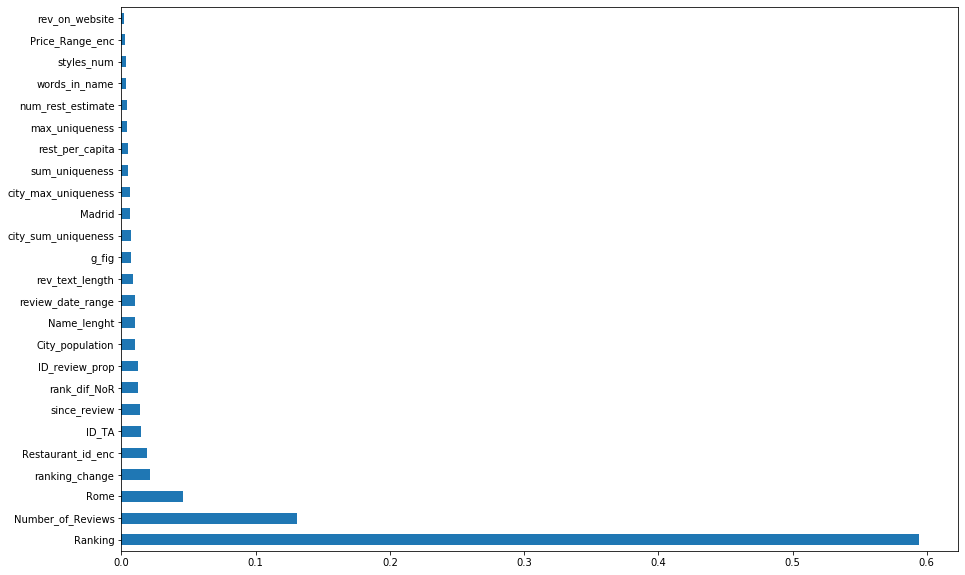

In [287]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (15,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

MAE: 0.232775, MAE: 0.22765649999999996,  MAE: 0.21642549999999997, MAE: 0.209511
MAE: 0.20496099999999998, MAE: 0.20267699999999997, 
MAE: 0.199917 rank_dif  
MAE: 0.20157899999999998 rank_dif_NoR  
MAE: 0.19952899999999998   
MAE: 0.20308449999999997 prop_num_range  
MAE: 0.20128349999999998 g_fig  
MAE: 0.204122 words_in_name  
MAE: 0.2004875 заполнение пропусков в NoR 1 а не 0  


## Вот по каким критериям проект будет оценивать ментор:

 - Качество кода (ясность, соответствие стандартам оформления pep-8, наличие комментариев).
 - Наличие визуализации с выводами (корреляция и важность признаков).
 - Feature Engineering и обогащение датасета (4 - наличие редких/уникальных предикторов модели).
 - Работа с метрикой МАЕ.
 - Использование внешних источников данных.

# ПОДВАЛ

In [99]:
%%time

select_by_RFR = pd.Series(regr.feature_importances_, index=X.columns)
select_by_RFR = select_by_RFR.sort_values(ascending=False).index.drop(cuisine_styles + data.City.unique().tolist())

for tres in range(3,len(select_by_RFR)):
    X_train_tres = X_train.drop(columns=select_by_RFR[tres:])
    X_test_tres = X_test.drop(columns=select_by_RFR[tres:])
    regr.fit(X_train_tres, y_train)
    y_pred = regr.predict(X_test_tres)
    y_pred_round = [(y*2).round()/2 if abs(y - t)<0.25 else y for y,t in zip(y_pred,y_test)]
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred_round), 'trs = ', tres)

MAE: 0.14524125 trs =  3
MAE: 0.14518125000000004 trs =  4
MAE: 0.138816875 trs =  5
MAE: 0.13619 trs =  6
MAE: 0.13471375 trs =  7
MAE: 0.13539249999999997 trs =  8
MAE: 0.1334625 trs =  9
MAE: 0.133943125 trs =  10
MAE: 0.13317812499999995 trs =  11
MAE: 0.13374624999999998 trs =  12
MAE: 0.13309812499999998 trs =  13
MAE: 0.132278125 trs =  14
MAE: 0.1328675 trs =  15
MAE: 0.133256875 trs =  16
MAE: 0.133165625 trs =  17
MAE: 0.13286625 trs =  18
MAE: 0.13298624999999997 trs =  19
MAE: 0.13307875000000002 trs =  20
MAE: 0.132334375 trs =  21
MAE: 0.13272187500000002 trs =  22
MAE: 0.13266624999999999 trs =  23
Wall time: 16min 42s


In [57]:
columns = dffm.columns.drop(cuisine_styles + data.City.unique().tolist())
select_by_corr = dffm[columns].corr().Rating.abs().sort_values(ascending = False)[1:].index

for tres in range(3,len(select_by_corr)):
    X_train_tres = X_train.drop(columns=select_by_corr[tres:])
    X_test_tres = X_test.drop(columns=select_by_corr[tres:])
    regr.fit(X_train_tres, y_train)
    y_pred = regr.predict(X_test_tres)
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred), 'trs = ', tres)

MAE: 0.2898905 trs =  3
MAE: 0.2764275 trs =  4
MAE: 0.2130075 trs =  5
MAE: 0.21271900000000002 trs =  6
MAE: 0.2132755 trs =  7
MAE: 0.21299049999999997 trs =  8
MAE: 0.2136915 trs =  9
MAE: 0.21322699999999994 trs =  10
MAE: 0.212784 trs =  11
MAE: 0.201004 trs =  12
MAE: 0.201352 trs =  13
MAE: 0.20064449999999998 trs =  14
MAE: 0.199351 trs =  15
MAE: 0.20003799999999997 trs =  16
MAE: 0.200079 trs =  17
MAE: 0.1998325 trs =  18
MAE: 0.20047800000000002 trs =  19
MAE: 0.20039449999999998 trs =  20


df['Restaurant_id_enc'] = df.Restaurant_id.str[3:].astype(int)

df = pd.concat([df,pd.get_dummies(df.City)],axis=1)

df.Cuisine_Style = df.Cuisine_Style.fillna("['Nan_Style']").str[2:-2].str.split("', '")
cuisine_styles = sorted(set(df.Cuisine_Style.sum()))
for style in cuisine_styles:
    df[style] = df.Cuisine_Style.apply(lambda x: int(style in x))

scaler = MinMaxScaler()
grouped_by_City = df.groupby('City')
for group in grouped_by_City.groups:
    index = grouped_by_City.groups[group]
    scaled_values = scaler.fit_transform(df[['Ranking']].loc[index])
    df.Ranking.loc[index] = pd.Series(scaled_values.flatten(), index=index)
    
price_range_encod = {'$': 1, '$$ - $$$': 2, '$$$$': 3, 'no range': 0}
df['Price_Range_enc'] = df.Price_Range.fillna('no range').map(price_range_encod)

df.Number_of_Reviews.fillna(1,inplace=True)
scaler = MinMaxScaler()
grouped_by_City = df.groupby('City')
for group in grouped_by_City.groups:
    index = grouped_by_City.groups[group]
    scaled_values = scaler.fit_transform(df[['Number_of_Reviews']].loc[index])
    df.Number_of_Reviews.loc[index] = pd.Series(scaled_values.flatten(), index=index)

df.ID_TA = df.ID_TA.str[1:].astype(int)


MAE: 0.210589 trs =  3
MAE: 0.21042199999999997 trs =  4
MAE: 0.20479999999999998 trs =  5
MAE: 0.2042025 trs =  6
MAE: 0.20166749999999997 trs =  7
MAE: 0.202018 trs =  8
MAE: 0.202546 trs =  9
MAE: 0.20191349999999997 trs =  10
MAE: 0.200967 trs =  11
MAE: 0.20138699999999998 trs =  12
MAE: 0.20064449999999998 trs =  13
MAE: 0.20079450000000001 trs =  14
MAE: 0.2003515 trs =  15
MAE: 0.20031100000000002 trs =  16
MAE: 0.20079149999999998 trs =  17
MAE: 0.2003165 trs =  18
MAE: 0.20070149999999998 trs =  19

MAE: 0.29426149999999995 trs =  3
MAE: 0.27816399999999997 trs =  4
MAE: 0.2141085 trs =  5
MAE: 0.21528699999999998 trs =  6
MAE: 0.21407349999999997 trs =  7
MAE: 0.2149685 trs =  8
MAE: 0.21503199999999997 trs =  9
MAE: 0.21430699999999997 trs =  10
MAE: 0.21309849999999997 trs =  11
MAE: 0.2017085 trs =  12
MAE: 0.20221050000000002 trs =  13
MAE: 0.2013085 trs =  14
MAE: 0.20027949999999997 trs =  15
MAE: 0.1998705 trs =  16
MAE: 0.2003835 trs =  17
MAE: 0.200641 trs =  18
MAE: 0.2002875 trs =  19

In [59]:
len(cuisine_styles + df.City.unique().tolist())

157

In [60]:
y_pred[:10]

array([1.65 , 3.335, 4.14 , 4.655, 4.31 , 4.17 , 3.03 , 4.07 , 4.865,
       3.41 ])

In [71]:
(y_pred*2).round()/2

array([1.5, 3.5, 4. , 4.5, 4.5, 4. , 3. , 4. , 5. , 3.5])

In [69]:
aa.round()/2

array([1.5, 3.5, 4. , 4.5, 4.5, 4. , 3. , 4. , 5. , 3.5])

In [ ]:
index = grouped_by_City.groups['Amsterdam']
 
city_cuistyle_list = data.Cuisine_Style.loc[index].sum()
city_uniqueness_of_cuisine = 1/pd.Series(city_cuistyle_list).value_counts()
city_uniqueness_of_cuisine

data.Cuisine_Style.loc[index].apply(city_cum_uniqueness)